## Import Libraries 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud
from datasets import load_dataset
# define the stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import dataset

In [2]:
data = load_dataset("yahoo_answers_topics.py")
#data = load_dataset("../../NLP_yahoo_questions/tools/yahoo_answers_topics/yahoo_answers_topics.py")

Found cached dataset yahoo_answers_topics (C:/Users/vilis/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()

In [4]:
df_train.head()

,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


## Preprocessing

In [5]:
# Converting integers to strings to understand each label independently.
categories = {0: 'Society & Culture', 1: 'Science & Mathematics', 2: 'Health', 3: 'Education & Reference',
              4: 'Computers & Internet', 5: 'Sports', 6: 'Business & Finance', 7: 'Entertainment & Music',
              8: 'Family & Relationships', 9: 'Politics & Government'}

In [6]:
# Mapping dict to target
df_train['topic_name'] = df_train['topic'].map(categories)
df_train.head(3) 

,id,topic,question_title,question_content,best_answer,topic_name
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...,Computers & Internet
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,Sports
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,Health


In [7]:
df_train.isna().sum()

id                  0
topic               0
question_title      0
question_content    0
best_answer         0
topic_name          0
dtype: int64

In [8]:
df_test.isna().sum()

id                  0
topic               0
question_title      0
question_content    0
best_answer         0
dtype: int64

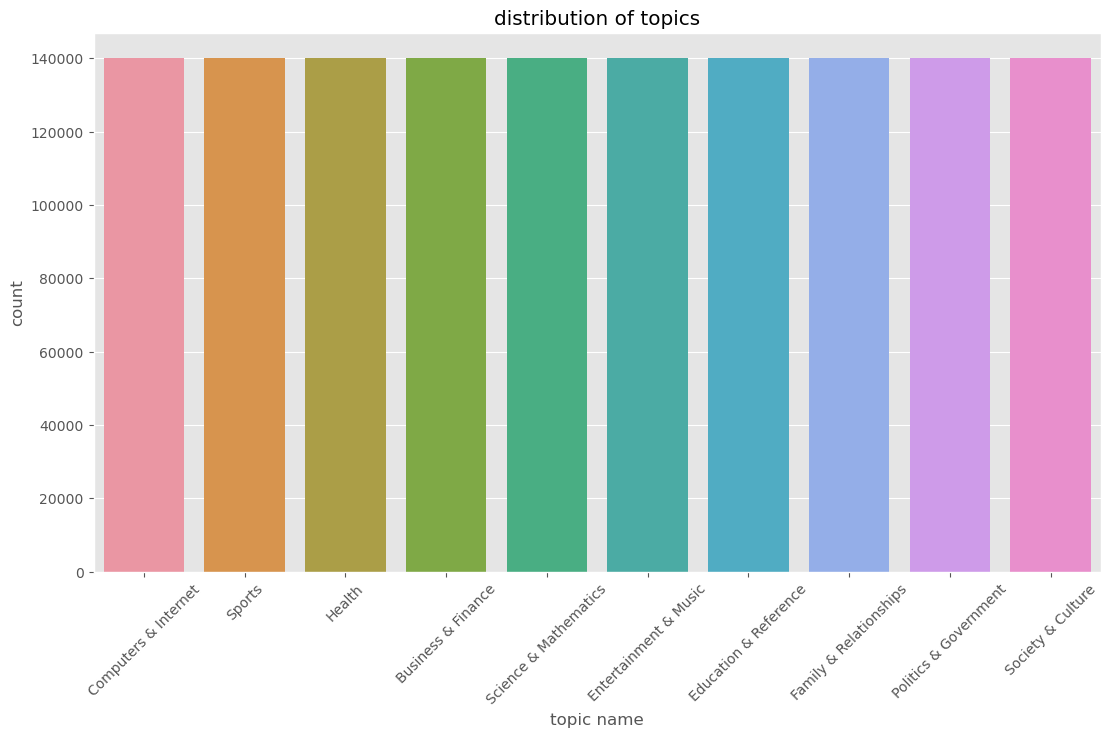

In [9]:
# Topic distribution 
plt.figure(figsize=(13, 7)) 
plt.style.use('ggplot')
sns.countplot(x = 'topic_name', data = df_train)
plt.title('distribution of topics', fontweight='bold')
plt.xlabel('topic name', fontweight='bold')
plt.xticks(rotation=45); 

##### Main conclusions

+ There are no null values
+ Topics are equally distributed
+ Since it's balanced, no need to do oversampling

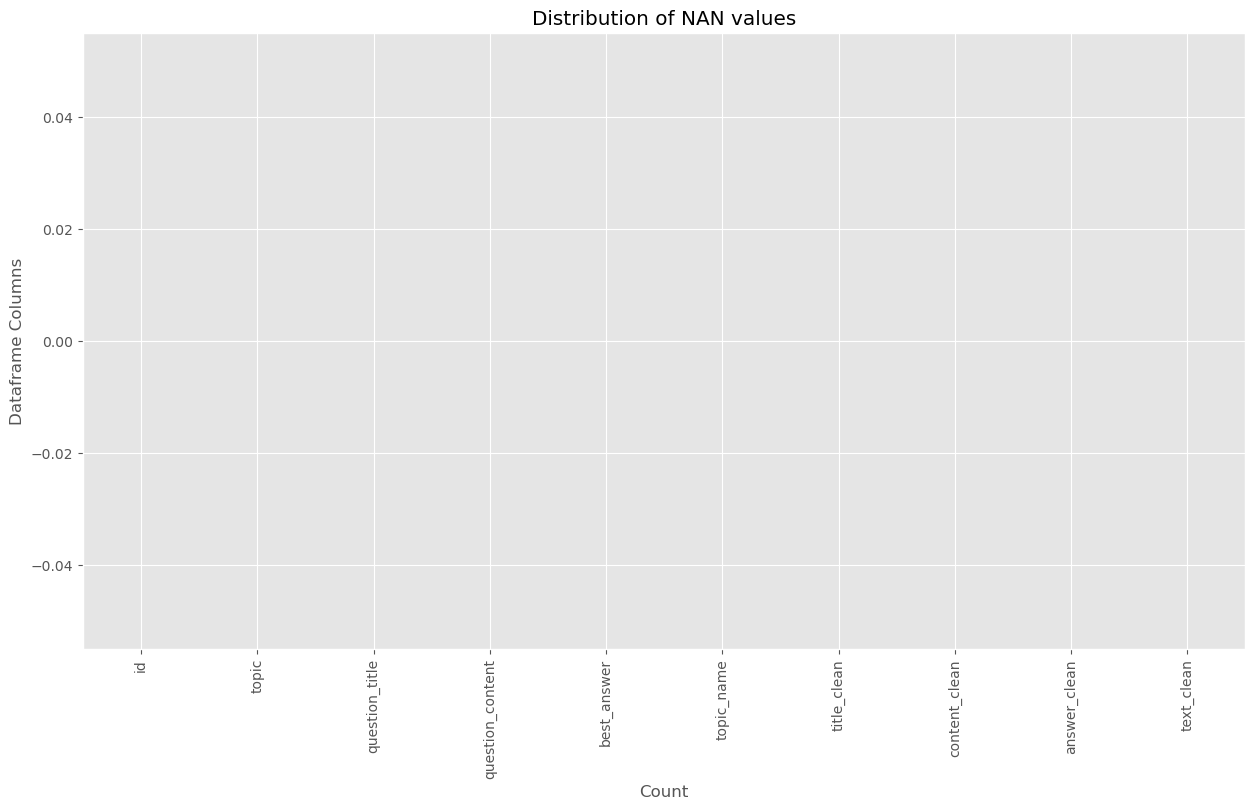

Missing data of training set
id                  0
topic               0
question_title      0
question_content    0
best_answer         0
topic_name          0
title_clean         0
content_clean       0
answer_clean        0
text_clean          0
dtype: int64


Missing data of test set
id                  0
topic               0
question_title      0
question_content    0
best_answer         0
dtype: int64


In [15]:
# Exploring NaN values in dataset
fig = plt.figure(figsize=(15, 8))
plt.title("Distribution of NAN values")
plt.xlabel('Count')
plt.ylabel('Dataframe Columns') 
df_train.isna().sum().sort_values(ascending = True).plot(kind = 'bar')
plt.show();

print("Missing data of training set")
print(df_train.isna().sum())
print("\n")
print("Missing data of test set")
print(df_test.isna().sum())

Insights from chart above: no data is missing

#### Preprocessing function

In [10]:
def preprocess_text(text):
    text = text.replace('\\n',' ').replace('<br />','')
    # tokenize the text into words
    tokens = nltk.word_tokenize(text.lower())
    # remove stopwords and punctuation
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    # perform stemming
    ##stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    # join the stemmed tokens back into a string
    ##preprocessed_text = ' '.join(stemmed_tokens)
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text.replace('[^\w\s]', '')

In [11]:
df_train['title_clean'] = df_train['question_title'].apply(preprocess_text)

In [12]:
df_train['content_clean'] = df_train['question_content'].apply(preprocess_text)

In [13]:
df_train['answer_clean'] = df_train['best_answer'].apply(preprocess_text)

In [14]:
df_train['text_clean'] = df_train['title_clean'] + ' ' + df_train['content_clean'] + ' ' + df_train['answer_clean']

In [16]:
df_train.to_csv("yahoo_train.csv", index=False)

In [19]:
df_clean = df_train[['topic','topic_name','text_clean']]

In [20]:
df_clean = df_clean[df_clean.topic.isin([0,1,2])]

In [21]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420000 entries, 2 to 1399998
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   topic       420000 non-null  int64 
 1   topic_name  420000 non-null  object
 2   text_clean  420000 non-null  object
dtypes: int64(1), object(2)
memory usage: 12.8+ MB


## Word cloud

+ Words with more ocurrences 

In [22]:
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='viridis', max_words=50)
df_train['title_clean'] = df_train['title_clean'].astype(str)

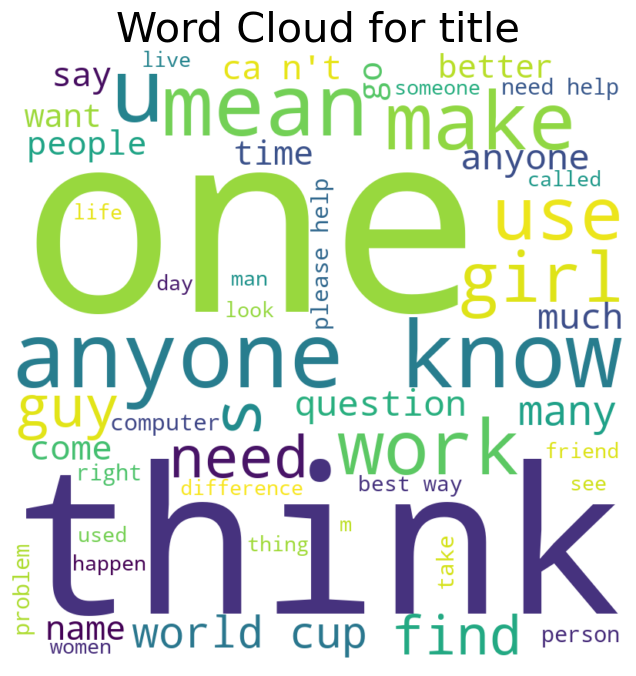

In [23]:
wordcloud_title = ' '.join(df_train['title_clean'])
wordcloud.generate(wordcloud_title)
# Plot the word cloud with a title
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for title', fontsize=30)
plt.show()

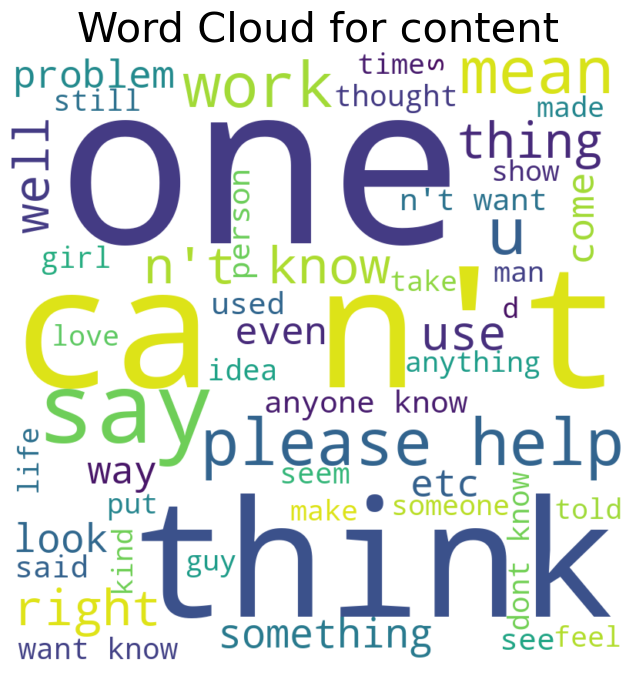

In [24]:
wordcloud_content = ' '.join(df_train['content_clean'])
wordcloud.generate(wordcloud_content)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for content', fontsize=30)
plt.show()

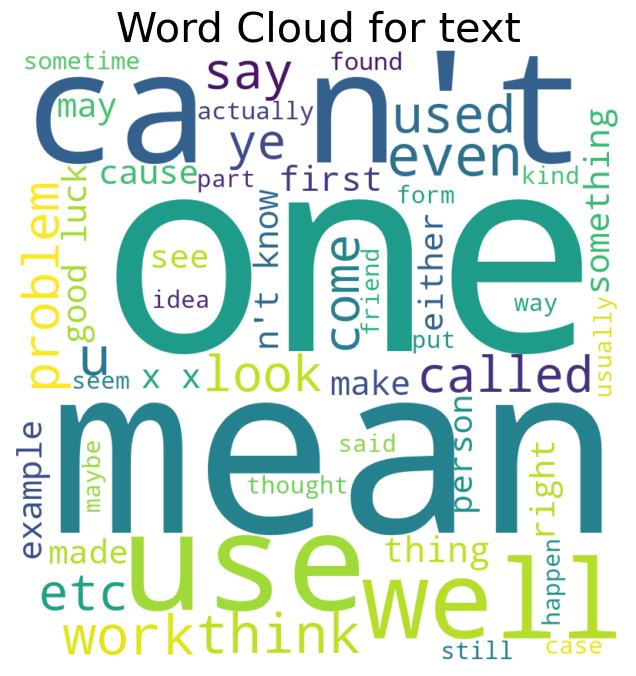

In [25]:
wordcloud_text = ' '.join(df_clean['text_clean'])
wordcloud.generate(wordcloud_text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for text', fontsize=30)
plt.show()

In [28]:
import spacy

### Spacy tokenizer

In [30]:
#spaCy tokenizer

nlp = spacy.load("en_core_web_sm", exclude=["ner"])
"""
  Objective: get the tokenizer you want, and quit stop words
  inputs: 
    - nlp, spacy model: the spacy model to consider
    - texts, list of texts: the list of texts to tokenize
    - stop_words, list of stop_words to avoid
  outputs: 
    - tokens, list of lists of tokens: the list of all sentences tokenized
"""

stop_words=[]
def spacy_tokenizer(texts, stop_words, nlp=nlp):
    tokens=[]
    docs=nlp.pipe(texts)
    for doc in docs:
        _tokens=[tok.text for tok in doc if tok.text not in stop_words]
        tokens.append(_tokens)
    return tokens

### Apply the function to tokenize topic 0

In [31]:
tokens_0 = spacy_tokenizer(df_clean.loc[df_clean.loc[:, 'topic'] == 0, 'text_clean'].values,stop_words,nlp)
tokens_0

[['pope',
  'get',
  'name',
  'br',
  'many',
  'different',
  'names',
  'decide',
  'next',
  'pope',
  "'s",
  'name',
  'selects'],
 ['anyone',
  'list',
  'short',
  'name',
  'common',
  'names',
  'examples',
  'xd',
  'br',
  'br',
  'bill',
  'william',
  'xd',
  'br',
  'dick',
  'ricard',
  'al',
  'albert',
  'alfred',
  'alan',
  'bob',
  'robert',
  'beth',
  'elizabeth',
  'bill',
  'william',
  'cathy',
  'catherine',
  'chris',
  'christopher',
  'deb',
  'bie',
  'deborah',
  'debra',
  'dick',
  'ie',
  'richard',
  'nie',
  'donald',
  'dom',
  'domenic',
  'dominic',
  'ed',
  'die',
  'dy',
  'edward',
  'fred',
  'dy',
  'die',
  'frederick',
  'jim',
  'mie',
  'james',
  'joe',
  'joseph',
  'kate',
  'katherine',
  'kim',
  'kimberl',
  'e',
  'larry',
  'lawrence',
  'liz',
  'elizabeth',
  'maggie',
  'margaret',
  'margy',
  'ie',
  'margaret',
  'matt',
  'ie',
  'matthew',
  'mike',
  'michael',
  'nick',
  'nicholas',
  'peggy',
  'margaret',
  'phil',


### Now we repeat for topics 1 and 2

In [37]:
tokens_1 = spacy_tokenizer(df_clean.loc[df_clean.loc[:, 'topic'] == 1, 'text_clean'].values,stop_words,nlp)
tokens_2 = spacy_tokenizer(df_clean.loc[df_clean.loc[:, 'topic'] == 2, 'text_clean'].values,stop_words,nlp)

In [40]:
#Un-nest list

tokens_0_flat = [word for sublist in tokens_0 for word in sublist]
tokens_1_flat = [word for sublist in tokens_1 for word in sublist]
tokens_2_flat = [word for sublist in tokens_1 for word in sublist]

In [33]:
#Counter words 

from collections import Counter

def most_common_words(words):
    word_counts = Counter(words)
    top_words = word_counts.most_common(50)
    return [word for word, count in top_words]

In [41]:
tokens_0_t50 = most_common_words(tokens_0_flat)
tokens_1_t50 = most_common_words(tokens_1_flat)
tokens_2_t50 = most_common_words(tokens_2_flat)

#### Print wordcloud for 50 common words by topic

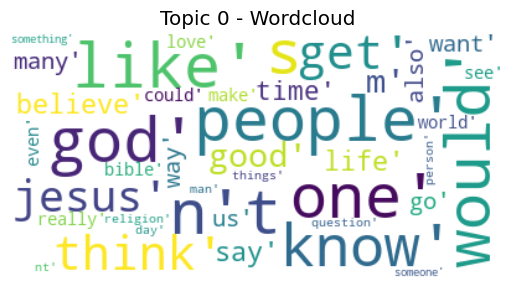

In [43]:
wordcloud_topic_0 = WordCloud(max_font_size=50, 
                               max_words=50, 
                               background_color="white").generate(str(tokens_0_t50))
plt.figure()
plt.title("Topic 0 - Wordcloud")
plt.imshow(wordcloud_topic_0, interpolation="bilinear")
plt.axis("off")
plt.show()



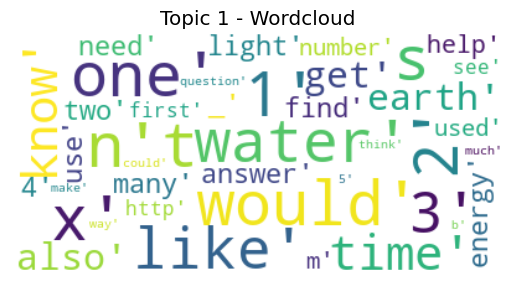

In [44]:
wordcloud_topic_1 = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(tokens_1_t50))
plt.figure()
plt.title("Topic 1 - Wordcloud")
plt.imshow(wordcloud_topic_1, interpolation="bilinear")
plt.axis("off")
plt.show()



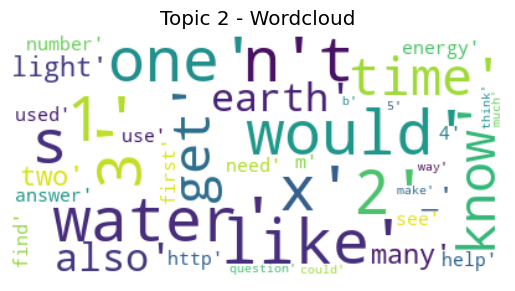

In [45]:
wordcloud_topic_2 = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(tokens_2_t50))
plt.figure()
plt.title("Topic 2 - Wordcloud")
plt.imshow(wordcloud_topic_2, interpolation="bilinear")
plt.axis("off")
plt.show()

+ It's possible to see that some are the words are repeated among topics like 'would', 'like', 'know'